In [ ]:
!pip install torch torchvision torchaudio
!pip install lightning
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 31.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import torch
import torchvision
import lightning as L
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader,random_split,Subset, SubsetRandomSampler
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchsummary import summary
from tqdm import tqdm
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, Callback
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-know-what-you-did-last-measurement-time

# Unzip the downloaded files and then remove the zip files
!unzip bgu-i-know-what-you-did-last-measurement-time.zip

Streaming output truncated to the last 5000 lines.
  inflating: unlabeled/unlabeled/95499.csv  
  inflating: unlabeled/unlabeled/955.csv  
  inflating: unlabeled/unlabeled/9550.csv  
  inflating: unlabeled/unlabeled/95500.csv  
  inflating: unlabeled/unlabeled/95501.csv  
  inflating: unlabeled/unlabeled/95502.csv  
  inflating: unlabeled/unlabeled/95503.csv  
  inflating: unlabeled/unlabeled/95504.csv  
  inflating: unlabeled/unlabeled/95505.csv  
  inflating: unlabeled/unlabeled/95506.csv  
  inflating: unlabeled/unlabeled/95507.csv  
  inflating: unlabeled/unlabeled/95508.csv  
  inflating: unlabeled/unlabeled/95509.csv  
  inflating: unlabeled/unlabeled/9551.csv  
  inflating: unlabeled/unlabeled/95510.csv  
  inflating: unlabeled/unlabeled/95511.csv  
  inflating: unlabeled/unlabeled/95512.csv  
  inflating: unlabeled/unlabeled/95513.csv  
  inflating: unlabeled/unlabeled/95514.csv  
  inflating: unlabeled/unlabeled/95515.csv  
  inflating: unlabeled/unlabeled/95516.csv  
  inflat

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

## **Part 1 - Data analysis**








In [ ]:
unlabeled_dir = '/content/unlabeled/unlabeled'

unlabeled_files = os.listdir(unlabeled_dir)

In [ ]:
chosen_file = '1000.csv'
file_path = os.path.join(unlabeled_dir, chosen_file)

unlabeled_data = pd.read_csv(file_path)

unlabeled_data.head()

,x [m],y [m],z [m]
0,0.248291,-0.539940,0.981346
1,0.251185,-0.546111,0.981167
2,0.253321,-0.551731,0.980899
3,0.255408,-0.558027,0.980578
4,0.257563,-0.563953,0.980564


In [ ]:
train_data = pd.read_csv('train.csv')

# sample_submission_data = pd.read_csv('sample_submission.csv')

In [ ]:
train_data.head()

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000
4,4,user07,using_phone,vicon,hand,left,61641,4000


In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'activity' column to get encoded labels
train_data['activity_encoded'] = label_encoder.fit_transform(train_data['activity'])

In [ ]:
train_data.head()

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length,activity_encoded
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000,5
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000,12
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000,12
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000,9
4,4,user07,using_phone,vicon,hand,left,61641,4000,7


## **Part 2 - Neural Network**

**a. validation strategy - train_test_split**

In [ ]:
from sklearn.model_selection import train_test_split

# Identify unique users
unique_subjects = train_data['userid'].unique()

# Split user IDs into training and validation sets
train_subjects, val_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Create training and validation sets
train_set = train_data[train_data['userid'].isin(train_subjects)]
val_set = train_data[train_data['userid'].isin(val_subjects)]

# Summary of the split
print(f"Training set includes {len(train_set)} samples from {len(train_subjects)} subjects.")
print(f"Validation set includes {len(val_set)} samples from {len(val_subjects)} subjects.")

Training set includes 38001 samples from 6 subjects.
Validation set includes 12247 samples from 2 subjects.


**Extract Statistical Features**

In [ ]:
import os
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_statistical_features(df, data_dir):
    """
    Extracts statistical features from time-series data corresponding to each row in the DataFrame.

    Parameters:
    - df: DataFrame with at least an 'id' column to locate the data files.
    - data_dir: The directory where the sequence data files are stored.

    Returns:
    - DataFrame with original data augmented with statistical features.
    """
    df = df.copy()

    means, stds, mins, maxs, medians, skews, kurtoses = [], [], [], [], [], [], []

    for _, row in df.iterrows():
        seq_id = row['id']
        file_path = os.path.join(data_dir, f"{seq_id}.csv")
        seq_df = pd.read_csv(file_path)

        # Filter by measurement type if necessary
        if "measurement type" in seq_df.columns:
            seq_df = seq_df[seq_df["measurement type"] == "acceleration [m/s/s]"]

        # Calculate statistical features for each axis
        for axis in ['x', 'y', 'z']:
            axis_data = seq_df[axis] if axis in seq_df.columns else seq_df[f"{axis} [m]"]
            means.append(axis_data.mean())
            stds.append(axis_data.std())
            mins.append(axis_data.min())
            maxs.append(axis_data.max())
            medians.append(axis_data.median())
            skews.append(skew(axis_data))  # Corrected
            kurtoses.append(kurtosis(axis_data))  # Corrected

    # Create a DataFrame with the calculated features
    features_df = pd.DataFrame({
        'x_mean': means[0::3], 'y_mean': means[1::3], 'z_mean': means[2::3],
        'x_std': stds[0::3], 'y_std': stds[1::3], 'z_std': stds[2::3],
        'x_min': mins[0::3], 'y_min': mins[1::3], 'z_min': mins[2::3],
        'x_max': maxs[0::3], 'y_max': maxs[1::3], 'z_max': maxs[2::3],
        'x_median': medians[0::3], 'y_median': medians[1::3], 'z_median': medians[2::3],
        'x_skew': skews[0::3], 'y_skew': skews[1::3], 'z_skew': skews[2::3],
        'x_kurtosis': kurtoses[0::3], 'y_kurtosis': kurtoses[1::3], 'z_kurtosis': kurtoses[2::3],
    })

    # Return the original DataFrame augmented with the new features
    return pd.concat([df.reset_index(drop=True), features_df], axis=1)

In [ ]:
# Load the train_features DataFrame from the saved CSV file
train_features_loaded = pd.read_csv('/content/train_features_1.csv')

# Load the val_features DataFrame from the saved CSV file
val_features_loaded = pd.read_csv('/content/val_features_1.csv')


In [ ]:
features_columns = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std','x_min', 'y_min', 'z_min','x_max', 'y_max', 'z_max','x_median', 'y_median', 'z_median', 'x_skew', 'y_skew', 'z_skew','x_kurtosis', 'y_kurtosis', 'z_kurtosis']

**1D- CNN & LSTM Models**

In [ ]:
class HARDataset(Dataset):
    def __init__(self, data, data_dir, transform=None, labeled=True):
        """
        Initializes the dataset.
        :param data: DataFrame for labeled data or list of filenames for unlabeled data.
        :param data_dir: Base directory where the data files are stored.
        :param transform: Optional transform to be applied on a sample.
        :param labeled: Flag indicating if the dataset is for labeled or unlabeled data.
        """
        self.data = data
        self.data_dir = data_dir
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labeled:
            # Handling labeled data
            seq_id, activity_label = self.data.iloc[idx]['id'], self.data.iloc[idx]['activity_encoded']
            seq_file_path = os.path.join(self.data_dir, f"{seq_id}.csv")
        else:# Handling unlabeled data
            seq_file_path = os.path.join(self.data_dir, self.data[idx])

        # Load sequence data
        seq_frame = pd.read_csv(seq_file_path)
        if self.labeled and "measurement type" in seq_frame.columns:
            # Filter by acceleration if it's labeled data and contains a 'measurement type' column
            seq_frame = seq_frame[seq_frame["measurement type"] == "acceleration [m/s/s]"]
            sequence_data = seq_frame.iloc[:, 1:4].values
        else:
            sequence_data = seq_frame.values  # Use all data if no filtering criteria

        # Apply transformations
        if self.transform:
            sequence_data = self.transform(sequence_data)
        sequence_data_tensor = torch.tensor(sequence_data, dtype=torch.float32)

        if self.labeled:
            activity_label = self.data.iloc[idx]['activity_encoded']
            activity_label_tensor = torch.tensor(activity_label, dtype=torch.long)
            return sequence_data_tensor, activity_label_tensor
        else:
            return sequence_data_tensor  # No label for unlabeled data

In [ ]:
#Padding from start for LSTM

def pad_sequences_from_start(batch, max_length=3000):
    # Initialize padded sequences and labels
    # Assuming each sequence has the same number of features
    num_features = batch[0][0].shape[1]
    padded_sequences = torch.zeros(len(batch), max_length, num_features)
    # labels = []
    labels = torch.zeros(len(batch), dtype=torch.long)

    for i, (sequence, label) in enumerate(batch):
        length = sequence.shape[0]
        start = max(max_length - length, 0)  # Calculate start index for sequence
        if length > max_length:
            # If sequence is longer than max_length, truncate it from the end
            padded_sequence = sequence[-max_length:]
        else:
            padded_sequences[i, start:] = sequence
            # # Calculate padding length
            # padding_length = max_length - length
            # # Create a zero tensor for padding
            # padding = torch.zeros(padding_length, num_features)
            # # Concatenate padding and sequence
            # padded_sequence = torch.cat((padding, sequence), dim=0)

        labels[i] = label

    #     padded_sequences[i] = padded_sequence
    #     labels.append(label)

    # labels = torch.stack(labels)
    return padded_sequences, labels

### **LSTM Model**


In [ ]:
import torch.nn.functional as F

class LSTMModel(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.save_hyperparameters()  # Automatically saves all arguments for later reference
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)  # Only apply dropout if num_layers > 1
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

        # save all the metrics
        self.TrainLossEs = []
        self.ValLossEs = []
        self.TrainAcc = []
        self.ValAcc = []

    def forward(self, x):
        # Automatically resets hidden state at the beginning of each batch
        batch_size = x.size(0)
        h0 = torch.zeros(self.hparams.num_layers, batch_size, self.hparams.hidden_size, device=self.device)
        c0 = torch.zeros(self.hparams.num_layers, batch_size, self.hparams.hidden_size, device=self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])  # Take the last time step output
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        predictions = self(sequences)
        loss = F.cross_entropy(predictions, labels)
        # Calculate accuracy
        _, predicted_labels = torch.max(predictions, 1)
        correct = (predicted_labels == labels).float().sum()
        accuracy = correct / labels.shape[0]
        self.TrainLossEs.append(loss.item())
        self.TrainAcc.append(accuracy.item())
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        predictions = self(sequences)
        loss = F.cross_entropy(predictions, labels)
        # Calculate accuracy
        _, predicted_labels = torch.max(predictions, 1)
        correct = (predicted_labels == labels).float().sum()
        accuracy = correct / labels.shape[0]
        self.ValLossEs.append(loss.item())
        self.ValAcc.append(accuracy.item())
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
        return [optimizer], [scheduler]

    def get_train_loss(self):
        return self.TrainLossEs

    def get_val_loss(self):
        return self.ValLossEs

    def get_train_acc(self):
        return self.TrainAcc

    def get_val_acc(self):
        return self.ValAcc

In [ ]:
# Create dataset instances
train_dataset = HARDataset(train_features_loaded, unlabeled_dir, labeled=True)
val_dataset = HARDataset(val_features_loaded, unlabeled_dir, labeled=True)

In [ ]:
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_sequences_from_start)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=pad_sequences_from_start)

In [ ]:
# sample 30% of the data from each set
subset_train_size = int(len(train_set) * 0.5)
subset_val_size = int(len(val_set) * 0.5)

train_subset_df = train_features_loaded.sample(n=subset_train_size, random_state=42)
val_subset_df = val_features_loaded.sample(n=subset_val_size, random_state=42)

# Create dataset instances using the subset DataFrames
train_dataset_subset = HARDataset(train_subset_df, unlabeled_dir, labeled=True)
val_dataset_subset = HARDataset(val_subset_df, unlabeled_dir, labeled=True)

# # Create data loaders using the subset datasets
# train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=32, shuffle=True, collate_fn=lambda x: pad_sequences_from_start(x, max_length=4000))
# val_dataloader_subset = DataLoader(val_dataset_subset, batch_size=32, shuffle=False, collate_fn=lambda x: pad_sequences_from_start(x, max_length=4000))

# Create data loaders using the subset datasets
train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=64, shuffle=True, collate_fn=fixed_padding)
val_dataloader_subset = DataLoader(val_dataset_subset, batch_size=64, shuffle=False, collate_fn=fixed_padding)

In [ ]:
for i, (x, y) in enumerate(train_dataloader):
    if i == 5:
        break
    print(f"Batch {i+1}:")
    print(f"X shape: {x.shape}")
    print(f"y shape: {y.shape}")
    print(f"y: {y}")
    print()

Batch 1:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([13, 10,  2, 11,  8, 12, 13, 10, 16,  8,  7, 16,  1, 17, 11, 10, 16, 12,
        10, 10,  9,  8, 11, 10, 16, 14,  1, 10,  0,  8, 16, 17,  7, 11, 12,  9,
        11,  8,  7,  7,  2,  1, 10,  4,  4, 10,  7, 11,  0, 10, 12,  5,  7,  4,
         7,  3,  6,  9, 16, 13,  9, 15, 11, 12])

Batch 2:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([12, 15,  9,  6, 10, 10, 12, 11, 15, 12, 10,  1,  9, 14, 11,  4,  0,  7,
        10, 11,  9,  2,  6, 12, 15, 12, 11, 10,  3,  8, 14,  2, 17, 13, 11,  2,
         1, 13, 17,  7,  4, 13, 10,  7, 15,  7,  7,  9, 12,  7,  4, 16,  4,  9,
         1,  1,  9,  7,  9, 12,  1, 12,  9,  1])

Batch 3:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([ 9, 12,  1,  9, 11, 12,  7,  3, 15, 13,  9,  9, 11, 16, 16, 10,  6,  1,
        12,  3, 17, 14, 12,  3, 10, 15,  7, 13,  8,  7, 10, 11,  7,  0, 16,  2,
         7, 14,  4, 15, 14, 12,  2, 10, 1

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

def train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=20, patience=5):

    # Logging
    logger = TensorBoardLogger("lightning_logs", name="LSTM Models")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        monitor='val_loss',  # Save the model based on the validation loss
        filename='LSTM-{epoch:02d}-{val_loss:.2f}'
        save_top_k=1,  # Save the best model only
        mode='min',  # Minimize validation loss
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        mode='max',
    )

    # Trainer
    trainer = L.Trainer(
        default_root_dir='checkpoints/',
        log_every_n_steps=5,
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        callbacks=[model_checkpoint, early_stopping],
        logger=logger
    )

    # Assuming 'trainer' is already defined and initialized
    if hasattr(trainer, 'logger') and trainer.logger:
        trainer.logger._log_graph = True  # This will log the model graph for visualization in TensorBoard
        trainer.logger._default_hp_metric = None  # This will disable the default hyperparameter metric logging

    # Start training
    trainer.fit(model, train_dataloader, val_dataloader)

    # Retrieve metrics from the trainer's logged metrics
    train_loss = trainer.logged_metrics.get('train_loss')
    val_loss = trainer.logged_metrics.get('val_loss')
    train_acc = trainer.logged_metrics.get('train_accuracy')
    val_acc = trainer.logged_metrics.get('val_accuracy')

    metrics = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
    }

    return model, metrics

In [ ]:
def epoch_array(matric_batch_array, num_epoch):
  """
  The  function calculates the mean matric value fo each epoch
  """
  res = []
  for i in np.array_split(matric_batch_array,num_epoch):
    res.append(float(np.mean(i)))
  return res

In [ ]:
def plot_acc_and_loss(model, num_epoch):
  """
  Helper function to plot the graphs
  """

  train_losses = epoch_array(model.get_train_loss(), num_epoch)
  val_losses = epoch_array(model.get_val_loss(), num_epoch)
  train_accs = epoch_array(model.get_train_acc(), num_epoch)
  val_accs = epoch_array(model.get_val_acc(), num_epoch)

  epochs = range(1, num_epoch + 1)

  # Plot training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_losses, '.-', label='Training Loss', color = '#609d9e')
  plt.plot(epochs, val_losses, '.-', label='Validation Loss', color = '#075052')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot training and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_accs, '.-', label='Training Accuracy', color = '#609d9e')
  plt.plot(epochs, val_accs, '.-', label='Validation Accuracy', color = '#075052')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# LSTM Model
model = LSTMModel(input_size=3, hidden_size=32, num_layers=5, num_classes=18)
model, metrics = train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=15, patience=5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | lstm    | LSTM    | 38.5 K
1 | fc1     | Linear  | 4.2 K 
2 | dropout | Dropout | 0     
3 | fc2     | Linear  | 2.3 K 
------------------------------------
45.1 K    Trainable params
0         Non-trainable params
45.1 K    Total params
0.180     Total estimated model params size (MB)
INF

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


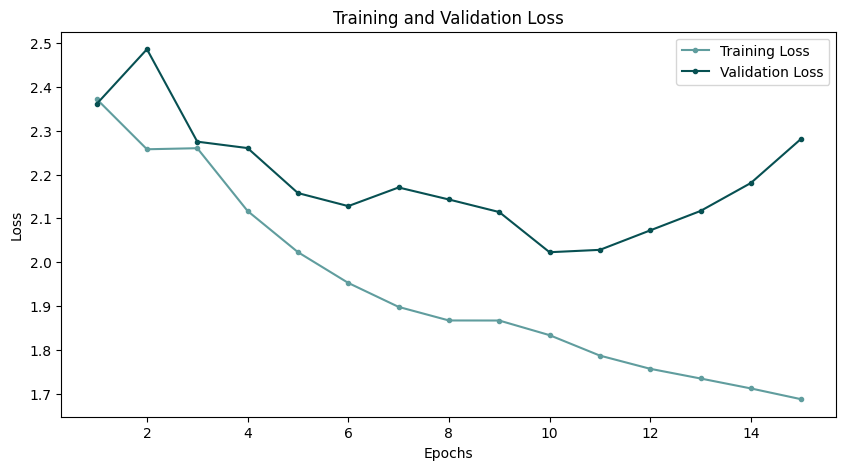

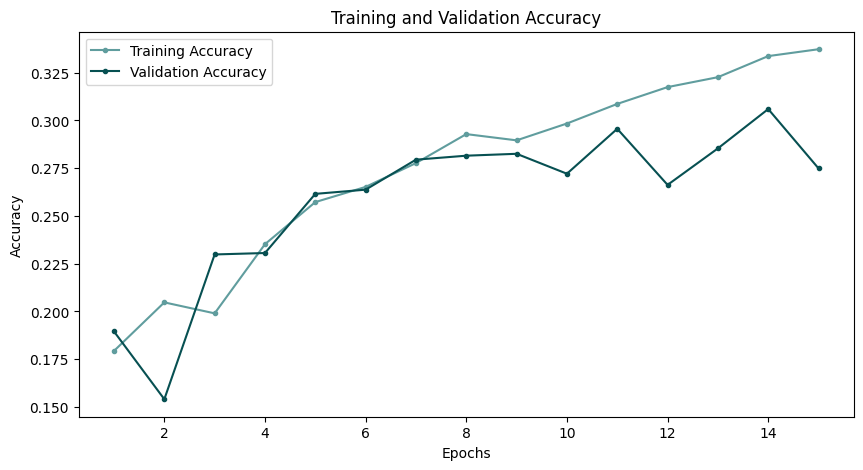

In [ ]:
plot_acc_and_loss(model, 15)

In [ ]:
def extract_predictions(model, dataloader):
    model.eval()
    model.freeze()
    predictions, labels, probabilities = [], [], []
    with torch.no_grad():
        for sequences, labels_batch in dataloader:
            outputs = model(sequences)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    return predictions, labels, probabilities

# Extract predictions and probabilities from the validation set
predictions, true_labels, probabilities = extract_predictions(model, val_dataloader)

In [ ]:
def visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5):
    # Convert numerical labels back to original activity names
    predicted_activities = label_encoder.inverse_transform(predictions)
    true_activities = label_encoder.inverse_transform(true_labels)

    # Prepare data for DataFrame
    data = []
    good_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred == true][:num_examples]
    for i in good_indices:
        data.append({
            'Index': i,
            'Type': 'Good',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    bad_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true][:num_examples]
    for i in bad_indices:
        data.append({
            'Index': i,
            'Type': 'Bad',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    uncertain_indices = sorted(range(len(probabilities)), key=lambda i: max(probabilities[i]))[:num_examples]
    for i in uncertain_indices:
        data.append({
            'Index': i,
            'Type': 'Uncertain',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    # Create and return DataFrame
    results_df = pd.DataFrame(data)

    # Round the 'Probability' column to 4 decimal places
    results_df['Probability'] = results_df['Probability'].round(4)

    return results_df

In [ ]:
visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5)

,Index,Type,Predicted,True,Probability
0,0,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,0.6632
1,1,Good,reading_book,reading_book,0.4891
2,4,Good,using_phone,using_phone,0.9623
3,5,Good,using_phone,using_phone,0.9552
4,6,Good,using_phone,using_phone,0.2401
5,2,Bad,using_phone,walking_with_object_underarm,0.4168
6,3,Bad,preparing_sandwich,walking_with_hands_in_pockets,0.2577
7,7,Bad,walking_freely,walking_holding_a_tray,0.1133
8,8,Bad,walking_holding_a_tray,reading_book,0.3411
9,9,Bad,walking_freely,walking_with_object_underarm,0.1133


### **Improved LSTM Model**

In [ ]:
class HARDataset(Dataset):
    def __init__(self, data, data_dir, transform=None, labeled=True):
        """
        Initializes the dataset.
        :param data: DataFrame for labeled data or list of filenames for unlabeled data.
        :param data_dir: Base directory where the data files are stored.
        :param transform: Optional transform to be applied on a sample.
        :param labeled: Flag indicating if the dataset is for labeled or unlabeled data.
        """
        self.data = data
        self.data_dir = data_dir
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labeled:
            # Handling labeled data
            seq_id, activity_label = self.data.iloc[idx]['id'], self.data.iloc[idx]['activity_encoded']
            seq_file_path = os.path.join(self.data_dir, f"{seq_id}.csv")
        else:# Handling unlabeled data
            seq_file_path = os.path.join(self.data_dir, self.data[idx])

        # Load sequence data
        seq_frame = pd.read_csv(seq_file_path)
        if self.labeled and "measurement type" in seq_frame.columns:
            # Filter by acceleration if it's labeled data and contains a 'measurement type' column
            seq_frame = seq_frame[seq_frame["measurement type"] == "acceleration [m/s/s]"]
            sequence_data = seq_frame.iloc[:, 1:4].values
        else:
            sequence_data = seq_frame.values  # Use all data if no filtering criteria

        # Apply transformations
        if self.transform:
            sequence_data = self.transform(sequence_data)
        sequence_data_tensor = torch.tensor(sequence_data, dtype=torch.float32)

        if self.labeled:
            activity_label = self.data.iloc[idx]['activity_encoded']
            activity_label_tensor = torch.tensor(activity_label, dtype=torch.long)
            return sequence_data_tensor, activity_label_tensor
        else:
            return sequence_data_tensor  # No label for unlabeled data

In [ ]:
#Padding from start for LSTM

def pad_sequences_from_start(batch, max_length=3000):
    # Initialize padded sequences and labels
    # Assuming each sequence has the same number of features
    num_features = batch[0][0].shape[1]
    padded_sequences = torch.zeros(len(batch), max_length, num_features)
    # labels = []
    labels = torch.zeros(len(batch), dtype=torch.long)

    for i, (sequence, label) in enumerate(batch):
        length = sequence.shape[0]
        start = max(max_length - length, 0)  # Calculate start index for sequence
        if length > max_length:
            # If sequence is longer than max_length, truncate it from the end
            padded_sequence = sequence[-max_length:]
        else:
            padded_sequences[i, start:] = sequence

        labels[i] = label

    return padded_sequences, labels

In [ ]:
# Create dataset instances
train_dataset = HARDataset(train_features_loaded, unlabeled_dir, labeled=True)
val_dataset = HARDataset(val_features_loaded, unlabeled_dir, labeled=True)

In [ ]:
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_sequences_from_start)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=pad_sequences_from_start)

In [ ]:
for i, (x, y) in enumerate(train_dataloader):
    if i == 5:
        break
    print(f"Batch {i+1}:")
    print(f"X shape: {x.shape}")
    print(f"y shape: {y.shape}")
    print(f"y: {y}")
    print()

Batch 1:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([11, 10, 11,  4, 13, 14, 16,  3, 11, 12,  2, 11, 10, 12, 10, 11,  1,  1,
        15, 11,  3, 10, 14, 13, 13, 15,  3, 13,  2, 16, 15, 10, 13,  4,  2, 12,
        13, 16, 12,  3,  2,  9,  9, 17, 11, 10,  8, 10,  3,  3, 10, 12, 10,  8,
         2, 13, 10,  6,  2, 13,  3, 15,  9, 11])

Batch 2:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([ 8, 11,  6, 13, 17,  9,  9,  1,  2,  4, 10,  8,  9,  1,  3, 10, 12,  9,
         7, 14, 13, 17,  3, 10, 10, 11,  5, 10,  2,  2, 14, 16,  7, 13, 14,  9,
         9, 14, 11,  7, 14,  0, 10, 11, 12, 10, 10, 17, 12,  1, 10, 12,  7,  1,
        11, 11, 10, 10,  9, 13, 11, 12,  7,  5])

Batch 3:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([12, 10, 17, 13, 12,  9,  8, 10, 17,  9,  3, 12,  3, 12, 14, 15, 14,  7,
        11,  3, 12, 10,  9,  2, 12,  3,  4,  2,  6, 12,  7, 11, 16, 11,  7,  4,
         7,  2, 12,  9, 10,  9,  8,  9, 1

In [ ]:
class ImprovedLSTMModel(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5, bidirectional=True):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0,
                            bidirectional=bidirectional)
        self.fc1 = nn.Linear(hidden_size * (2 if bidirectional else 1), 128)  # Adjust input size if bidirectional
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        self.layer_norm = nn.LayerNorm(hidden_size * (2 if bidirectional else 1))  # Layer normalization


        # save all the metrics
        self.TrainLossEs = []
        self.ValLossEs = []
        self.TrainAcc = []
        self.ValAcc = []

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.hparams.num_layers * (2 if self.hparams.bidirectional else 1),
                         batch_size, self.hparams.hidden_size, device=self.device)
        c0 = torch.zeros(self.hparams.num_layers * (2 if self.hparams.bidirectional else 1),
                         batch_size, self.hparams.hidden_size, device=self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(self.layer_norm(out[:, -1, :]))  # Apply layer normalization before the fully connected layer
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        predictions = self(sequences)
        loss = F.cross_entropy(predictions, labels)
        accuracy = (torch.argmax(predictions, dim=1) == labels).float().mean()
        self.TrainLossEs.append(loss.item())
        self.TrainAcc.append(accuracy.item())
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        predictions = self(sequences)
        loss = F.cross_entropy(predictions, labels)
        accuracy = (torch.argmax(predictions, dim=1) == labels).float().mean()
        self.ValLossEs.append(loss.item())
        self.ValAcc.append(accuracy.item())
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
        return [optimizer], [scheduler]


    def get_train_loss(self):
        return self.TrainLossEs

    def get_val_loss(self):
        return self.ValLossEs

    def get_train_acc(self):
        return self.TrainAcc

    def get_val_acc(self):
        return self.ValAcc


In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

def train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=10, patience=5):

    # Logging
    logger = TensorBoardLogger("lightning_logs", name="LSTM Models")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        monitor='val_loss',  # Save the model based on the validation loss
        # filename='CNN1D-{epoch:02d}-{val_loss:.2f}',
        filename='ImprovedLSTMModel-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,  # Save the best model only
        mode='min',  # Minimize validation loss
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        mode='max',
    )

    # Trainer
    trainer = L.Trainer(
        default_root_dir='checkpoints/',
        log_every_n_steps=5,
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        callbacks=[model_checkpoint, early_stopping],
        logger=logger
    )

    # Assuming 'trainer' is already defined and initialized
    if hasattr(trainer, 'logger') and trainer.logger:
        trainer.logger._log_graph = True  # This will log the model graph for visualization in TensorBoard
        trainer.logger._default_hp_metric = None  # This will disable the default hyperparameter metric logging

    # Start training
    trainer.fit(model, train_dataloader, val_dataloader)

    # Retrieve metrics from the trainer's logged metrics
    train_loss = trainer.logged_metrics.get('train_loss')
    val_loss = trainer.logged_metrics.get('val_loss')
    train_acc = trainer.logged_metrics.get('train_accuracy')
    val_acc = trainer.logged_metrics.get('val_accuracy')

    metrics = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
    }

    return model, metrics

In [ ]:
def epoch_array(matric_batch_array, num_epoch):
  """
  The  function calculates the mean matric value fo each epoch
  """
  res = []
  for i in np.array_split(matric_batch_array,num_epoch):
    res.append(float(np.mean(i)))
  return res

In [ ]:
def plot_acc_and_loss(model, num_epoch):
  """
  Helper function to plot the graphs
  """

  train_losses = epoch_array(model.get_train_loss(), num_epoch)
  val_losses = epoch_array(model.get_val_loss(), num_epoch)
  train_accs = epoch_array(model.get_train_acc(), num_epoch)
  val_accs = epoch_array(model.get_val_acc(), num_epoch)

  epochs = range(1, num_epoch + 1)

  # Plot training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_losses, '.-', label='Training Loss', color = '#609d9e')
  plt.plot(epochs, val_losses, '.-', label='Validation Loss', color = '#075052')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot training and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_accs, '.-', label='Training Accuracy', color = '#609d9e')
  plt.plot(epochs, val_accs, '.-', label='Validation Accuracy', color = '#075052')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# Improved LSTMM odel
model = ImprovedLSTMModel(input_size=3, hidden_size=32, num_layers=5, num_classes=18)
model, metrics = train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=10, patience=5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type      | Params
-----------------------------------------
0 | lstm       | LSTM      | 109 K 
1 | fc1        | Linear    | 8.3 K 
2 | dropout    | Dropout   | 0     
3 | fc2        | Linear    | 2.3 K 
4 | layer_norm | LayerNorm | 128   
-----------------------------------------
120 K     Trainable params
0         Non-trainable params
120 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

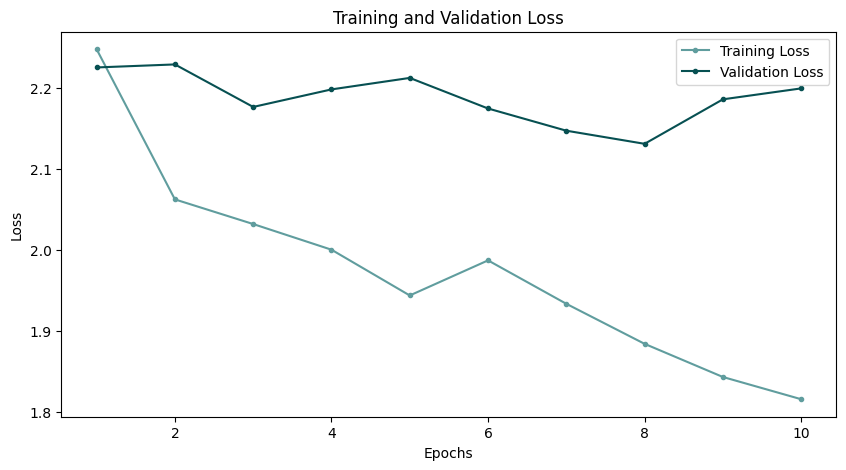

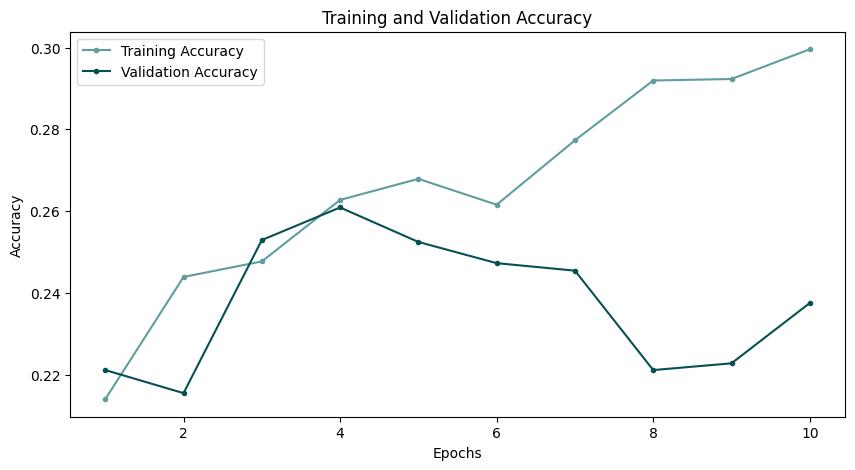

In [ ]:
plot_acc_and_loss(model, 10)

In [ ]:
def extract_predictions(model, dataloader):
    model.eval()
    model.freeze()
    predictions, labels, probabilities = [], [], []
    with torch.no_grad():
        for sequences, labels_batch in dataloader:
            outputs = model(sequences)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    return predictions, labels, probabilities

# Extract predictions and probabilities from the validation set
predictions, true_labels, probabilities = extract_predictions(model, val_dataloader)

In [ ]:
def visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5):
    # Convert numerical labels back to original activity names
    predicted_activities = label_encoder.inverse_transform(predictions)
    true_activities = label_encoder.inverse_transform(true_labels)

    # Prepare data for DataFrame
    data = []
    good_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred == true][:num_examples]
    for i in good_indices:
        data.append({
            'Index': i,
            'Type': 'Good',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    bad_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true][:num_examples]
    for i in bad_indices:
        data.append({
            'Index': i,
            'Type': 'Bad',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    uncertain_indices = sorted(range(len(probabilities)), key=lambda i: max(probabilities[i]))[:num_examples]
    for i in uncertain_indices:
        data.append({
            'Index': i,
            'Type': 'Uncertain',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    # Create and return DataFrame
    results_df = pd.DataFrame(data)

    # Round the 'Probability' column to 4 decimal places
    results_df['Probability'] = results_df['Probability'].round(4)

    return results_df

In [ ]:
visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5)

,Index,Type,Predicted,True,Probability
0,0,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,0.8317
1,3,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,0.5923
2,4,Good,using_phone,using_phone,0.9454
3,5,Good,using_phone,using_phone,0.9509
4,12,Good,walking_freely,walking_freely,0.1263
5,1,Bad,idle,reading_book,0.2576
6,2,Bad,using_phone,walking_with_object_underarm,0.4845
7,6,Bad,walking_with_object_underarm,using_phone,0.2054
8,7,Bad,walking_freely,walking_holding_a_tray,0.1263
9,8,Bad,walking_holding_a_tray,reading_book,0.4530
